# Faster RCNN Pipeline Guide (MVTec Bottle)

This notebook walks through the entire workflow: environment setup, data preparation, training, inference, and evaluation.


## Table of Contents
1. Environment setup & verification
2. Balanced dataset preparation
3. Model training
4. Inference & visualization
5. Result evaluation


## 1. Environment Setup & Verification
All required packages are listed in `requirements_fasterrcnn.txt`. Activate the virtual environment with `source venv/bin/activate` before running the commands below.


In [1]:
# Check Python and core library versions
import sys, torch, torchvision
print('Python version:', sys.version)
print('Torch version:', torch.__version__, '| CUDA available:', torch.cuda.is_available())
print('Torchvision version:', torchvision.__version__)


Python version: 3.14.0 (main, Oct  7 2025, 09:34:52) [Clang 17.0.0 (clang-1700.3.19.1)]
Torch version: 2.9.0 | CUDA available: False
Torchvision version: 0.24.0


In [2]:
# Quick install command for dependencies (run if needed)
# !pip install -r requirements_fasterrcnn.txt


## 2. Prepare a Balanced Dataset
The `prepare_balanced_dataset.py` script gathers both good and defect images and splits them into balanced train/validation folders.


### Compare Original vs. Balanced Dataset Sizes
Use this section to quickly inspect how many images exist in the original MVTec Bottle dataset (train/test) versus the balanced dataset created for training (train/val).


In [3]:
from pathlib import Path
import pandas as pd

IMAGE_EXTS = {'.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'}
AUG_SUFFIXES = ('_flip_h', '_flip_v', '_rot_p15', '_rot_n15', '_blur')


def is_augmented(stem: str) -> bool:
    return any(stem.endswith(sfx) for sfx in AUG_SUFFIXES)


def collect_records(root: Path, label: str, splits: list[str]) -> pd.DataFrame:
    rows = []
    if not root.exists():
        print(f"⚠️  Folder not found: {root}")
        return pd.DataFrame()

    for split in splits:
        split_dir = root / split
        if not split_dir.exists():
            continue
        class_dirs = sorted(p for p in split_dir.iterdir() if p.is_dir())
        for cls_dir in class_dirs:
            for img_path in cls_dir.iterdir():
                if not img_path.is_file() or img_path.suffix.lower() not in IMAGE_EXTS:
                    continue
                rows.append({
                    'dataset': label,
                    'split': split,
                    'class': cls_dir.name,
                    'image': img_path.name,
                    'variant': 'augment' if is_augmented(img_path.stem) else 'original'
                })
    return pd.DataFrame(rows)


orig_root = Path('datasets/mvtec/bottle')
balanced_root = Path('datasets/mvtec_balanced/bottle')

orig_df = collect_records(orig_root, 'mvtec_original', ['train', 'test'])
balanced_df = collect_records(balanced_root, 'balanced_current', ['train', 'val'])

comparison_df = pd.concat([orig_df, balanced_df], ignore_index=True)

if comparison_df.empty:
    print('⚠️  No data to compare. Please verify the dataset folders.')
else:
    total_orig = len(orig_df)
    total_bal = len(balanced_df)
    print('Total original MVTec images:', total_orig)
    print('Total images after balancing/augmentation:', total_bal)

    overall_summary = (
        comparison_df
        .groupby(['dataset', 'split', 'class'])
        .size()
        .reset_index(name='images')
    )
    display(overall_summary)

    variant_summary = (
        comparison_df
        .groupby(['dataset', 'split', 'class', 'variant'])
        .size()
        .reset_index(name='images')
    )
    print('\nOriginal vs. augmented breakdown:')
    display(variant_summary)



Total original MVTec images: 292
Total images after balancing/augmentation: 1122


,dataset,split,class,images
0,balanced_current,train,defect,126
1,balanced_current,train,good,918
2,balanced_current,val,defect,10
3,balanced_current,val,good,68
4,mvtec_original,test,broken_large,20
5,mvtec_original,test,broken_small,22
6,mvtec_original,test,contamination,21
7,mvtec_original,test,good,20
8,mvtec_original,train,good,209



Original vs. augmented breakdown:


,dataset,split,class,variant,images
0,balanced_current,train,defect,augment,105
1,balanced_current,train,defect,original,21
2,balanced_current,train,good,augment,765
3,balanced_current,train,good,original,153
4,balanced_current,val,defect,original,10
5,balanced_current,val,good,original,68
6,mvtec_original,test,broken_large,original,20
7,mvtec_original,test,broken_small,original,22
8,mvtec_original,test,contamination,original,21
9,mvtec_original,test,good,original,20


### Augment the Training Set
After building the balanced dataset, you can generate extra samples with `augment_balanced_train.py`. The script applies flips, ±15° rotations, and light Gaussian blur directly inside `datasets/mvtec_balanced/bottle/train` to increase diversity before training.


In [4]:
# Run augmentation (uncomment to execute)
cmd = [
    './venv/bin/python',
    'augment_balanced_train.py',
    '--data_root', 'datasets/mvtec_balanced/bottle',
    '--splits', 'train',
    '--classes', 'good', 'defect'
]
print(' '.join(cmd))
# import subprocess
# subprocess.run(cmd, check=True)



./venv/bin/python augment_balanced_train.py --data_root datasets/mvtec_balanced/bottle --splits train --classes good defect


In [5]:
# Run the data-preparation script (uncomment to execute)
prep_cmd = [
    'python', 'prepare_balanced_dataset.py',
    '--source', 'datasets/mvtec/bottle',
    '--output', 'datasets/mvtec_balanced/bottle',
    '--train_ratio', '0.7',
    '--seed', '42'
]
print(' '.join(prep_cmd))
# import subprocess
# subprocess.run(prep_cmd, check=True)


python prepare_balanced_dataset.py --source datasets/mvtec/bottle --output datasets/mvtec_balanced/bottle --train_ratio 0.7 --seed 42


In [6]:
# Quick summary of image counts after preparation
import os
from collections import Counter
root = 'datasets/mvtec_balanced/bottle'
stats = {}
for split in ['train', 'val']:
    counts = Counter()
    for cls in ['good', 'defect']:
        cls_dir = os.path.join(root, split, cls)
        if os.path.exists(cls_dir):
            counts[cls] = len([f for f in os.listdir(cls_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
    stats[split] = counts
stats


{'train': Counter({'good': 918, 'defect': 126}),
 'val': Counter({'good': 68, 'defect': 10})}

## 3. Model Training
The model definition lives in `model.py` (ResNet50 or FPN backbone). The main training entry point is `train_balanced.py`.


In [7]:
# Example training command
train_cmd = [
    'python', 'train_balanced.py',
    '--data_root', 'datasets/mvtec_balanced/bottle',
    '--model_type', 'resnet50',
    '--epochs', '30',
    '--batch_size', '16',
    '--lr', '0.001',
    '--save_dir', 'runs/fasterrcnn_balanced'
]
print(' '.join(train_cmd))
# import subprocess
# subprocess.run(train_cmd, check=True)


python train_balanced.py --data_root datasets/mvtec_balanced/bottle --model_type resnet50 --epochs 30 --batch_size 16 --lr 0.001 --save_dir runs/fasterrcnn_balanced


In [8]:
# Inspect the most recent training run (if available)
import glob
run_dirs = sorted(glob.glob('runs/fasterrcnn_balanced/balanced_resnet50_*'))
if run_dirs:
    latest = run_dirs[-1]
    print('Latest run:', latest)
    print('Artifacts:', sorted(os.listdir(latest)))
else:
    print('No training results yet')


Latest run: runs/fasterrcnn_balanced/balanced_resnet50_20251114_005430
Artifacts: ['best_acc.pth', 'best_auc.pth', 'confusion_matrix.png', 'last.pth', 'training_curves.png']


### Quick check for a new image (with rotation + visualization)
The `rotate_and_test.py` script rotates an image (90°/180°/270°), saves the rotated copy, runs inference through `InferenceEngine`, and exports the probability visualization for Good/Defect. Use it to validate samples that were not part of the training set.


In [9]:
# Example rotate_and_test invocation (update the image path as needed)
rotate_cmd = [
    './venv/bin/python',
    'rotate_and_test.py',
    '--image', 'datasets/mvtec/bottle/test/good/000.png',  # replace with the image you want to test
    '--checkpoint', 'runs/fasterrcnn_balanced/balanced_resnet50_20251114_005430/best_acc.pth',
    '--model_type', 'resnet50',
    '--angle', '90',
    '--save_dir', 'runs/rotated_test'
]
print(' '.join(rotate_cmd))
import subprocess
subprocess.run(rotate_cmd, check=True)



./venv/bin/python rotate_and_test.py --image datasets/mvtec/bottle/test/good/000.png --checkpoint runs/fasterrcnn_balanced/balanced_resnet50_20251114_005430/best_acc.pth --model_type resnet50 --angle 90 --save_dir runs/rotated_test
Rotating image: datasets/mvtec/bottle/test/good/000.png
Angle: 90°
✓ Rotated image 90° and saved to: runs/rotated_test/000_rotated_90.png

Testing rotated image with model...
✓ Loaded checkpoint: runs/fasterrcnn_balanced/balanced_resnet50_20251114_005430/best_acc.pth
✓ Model type: resnet50
✓ Device: cpu
  - Val Accuracy: 98.72%
  - Val AUC: 0.9985
  ↪ Visualization saved to runs/rotated_test/pred_000_rotated_90.png

RESULTS
Original image: datasets/mvtec/bottle/test/good/000.png
Rotated image (90°): runs/rotated_test/000_rotated_90.png

Prediction: Good
Confidence: 99.93%
Probabilities:
  - Good: 99.93%
  - Defect: 0.07%

Visualization saved to: runs/rotated_test/pred_000_rotated_90.png


CompletedProcess(args=['./venv/bin/python', 'rotate_and_test.py', '--image', 'datasets/mvtec/bottle/test/good/000.png', '--checkpoint', 'runs/fasterrcnn_balanced/balanced_resnet50_20251114_005430/best_acc.pth', '--model_type', 'resnet50', '--angle', '90', '--save_dir', 'runs/rotated_test'], returncode=0)

### Visualize predictions for multiple rotation angles
To inspect an unseen image under several angles (0°, 90°, 180°, 270°, ...), rotate it directly inside the notebook, run `InferenceEngine`, and display the Good/Defect probability chart for each angle.


✓ Loaded checkpoint: runs/fasterrcnn_balanced/balanced_resnet50_20251114_005430/best_acc.pth
✓ Model type: resnet50
✓ Device: cpu
  - Val Accuracy: 98.72%
  - Val AUC: 0.9985


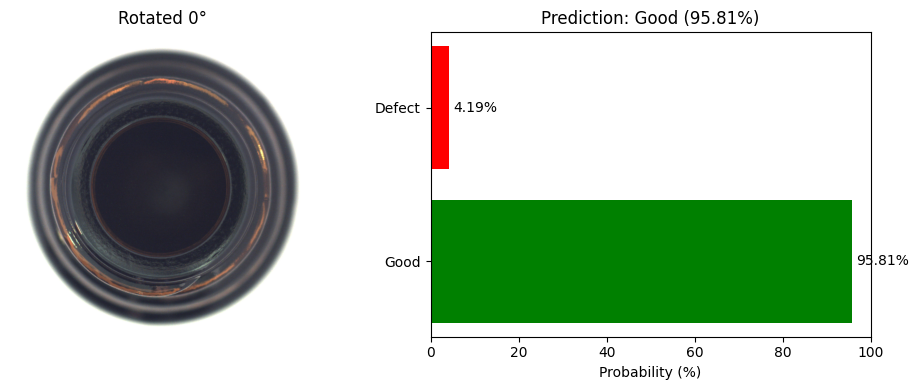

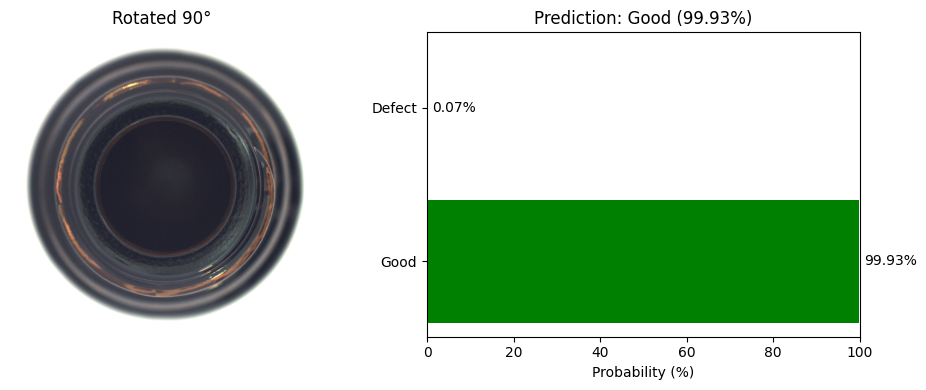

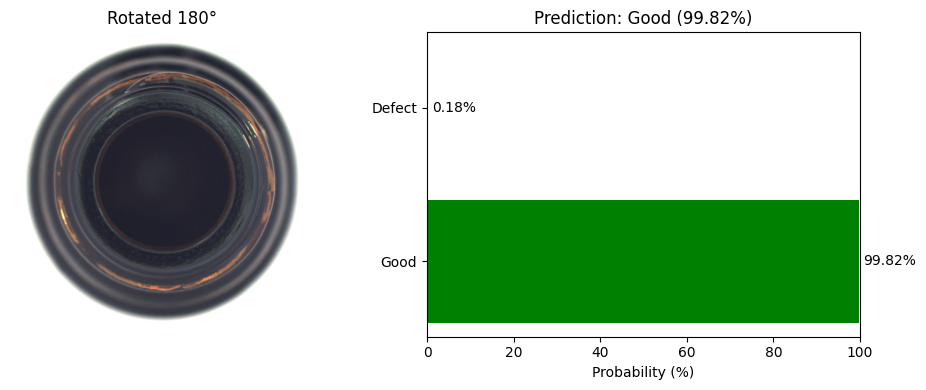

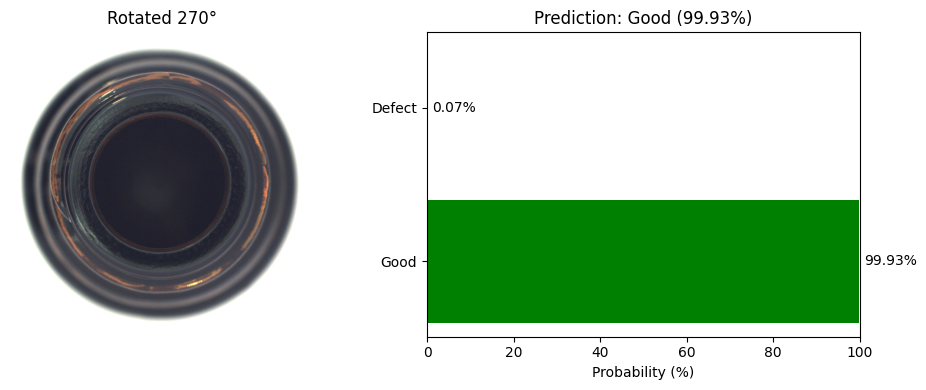

✓ Loaded checkpoint: runs/fasterrcnn_balanced/balanced_resnet50_20251114_005430/best_acc.pth
✓ Model type: resnet50
✓ Device: cpu
  - Val Accuracy: 98.72%
  - Val AUC: 0.9985


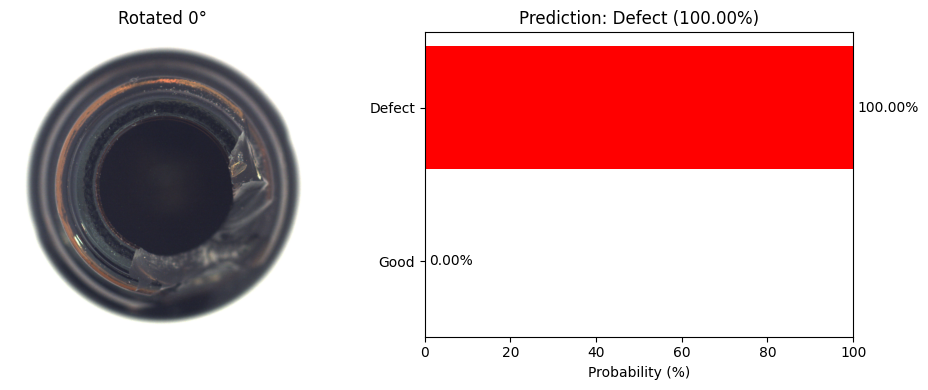

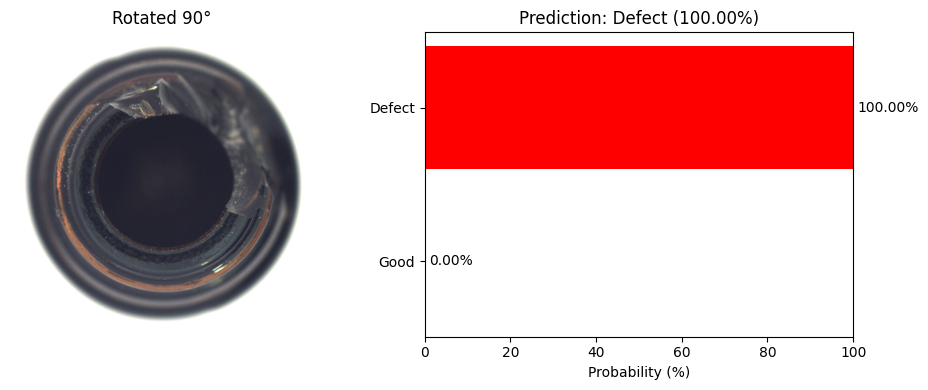

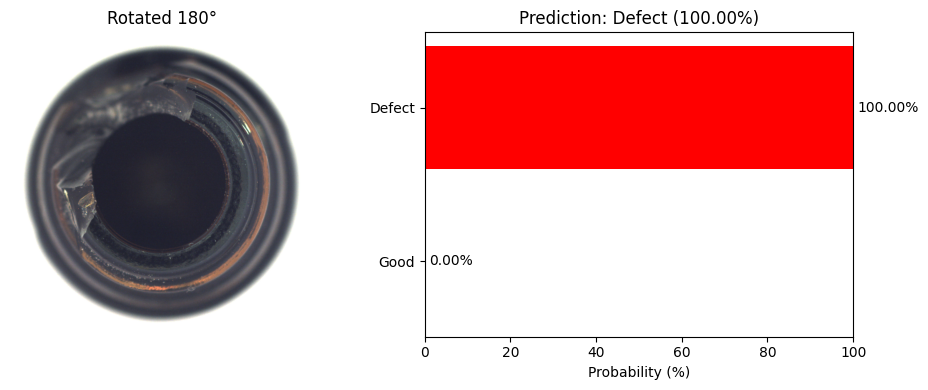

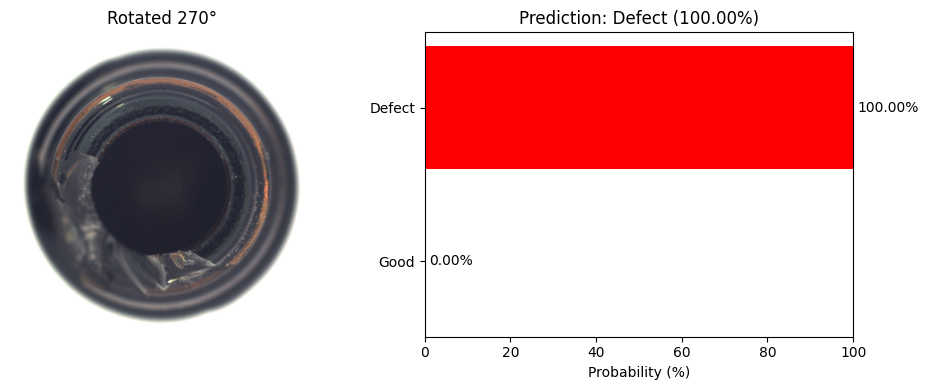

In [10]:
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

from inference import InferenceEngine, CLASS_NAMES


def visualize_rotations(
    image_path,
    angles=(0, 90, 180, 270),
    checkpoint='runs/fasterrcnn_balanced/balanced_resnet50_20251114_005430/best_acc.pth',
    model_type='resnet50',
    save_dir='runs/rotated_test'
):
    engine = InferenceEngine(checkpoint, model_type)
    base_img = Image.open(image_path).convert('RGB')
    os.makedirs(save_dir, exist_ok=True)

    results = []
    for angle in angles:
        rotated = base_img.rotate(angle, expand=True)
        tmp_path = Path(save_dir) / f"{Path(image_path).stem}_rot_{angle}.png"
        rotated.save(tmp_path)

        pred_idx, confidence, probs = engine.predict(tmp_path)
        results.append({
            'angle': angle,
            'prediction': CLASS_NAMES[pred_idx],
            'confidence': confidence,
            'prob_good': probs[0] * 100,
            'prob_defect': probs[1] * 100,
            'path': tmp_path
        })

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].imshow(rotated)
        axes[0].axis('off')
        axes[0].set_title(f"Rotated {angle}°")

        axes[1].barh(CLASS_NAMES, [p * 100 for p in probs], color=['green', 'red'])
        axes[1].set_xlim(0, 100)
        axes[1].set_xlabel('Probability (%)')
        axes[1].set_title(f"Prediction: {CLASS_NAMES[pred_idx]} ({confidence:.2f}%)")
        for y, p in enumerate(probs):
            axes[1].text(p * 100 + 1, y, f"{p*100:.2f}%", va='center')

        plt.tight_layout()
        plt.show()

    return results


analyze_results_good = visualize_rotations(
    image_path='datasets/mvtec/bottle/test/good/000.png',
    angles=[0, 90, 180, 270],
    checkpoint='runs/fasterrcnn_balanced/balanced_resnet50_20251114_005430/best_acc.pth',
    model_type='resnet50'
)
analyze_results_defect = visualize_rotations(
    image_path='datasets/mvtec/bottle/test/broken_large/000.png',
    angles=[0, 90, 180, 270],
    checkpoint='runs/fasterrcnn_balanced/balanced_resnet50_20251114_005430/best_acc.pth',
    model_type='resnet50'
)

## 4. Inference & Visualization
After training, use the `best_acc.pth` or `best_auc.pth` checkpoints. You can run inference via the `inference.py` CLI or directly through the `InferenceEngine` class.


In [11]:
# CLI example (replace <RUN> with the actual folder)
print('python inference.py --checkpoint runs/fasterrcnn_balanced/<RUN>/best_acc.pth \\\
 --model_type resnet50 --folder datasets/mvtec/bottle/test/good --save_dir runs/inference_final/good')


python inference.py --checkpoint runs/fasterrcnn_balanced/<RUN>/best_acc.pth \ --model_type resnet50 --folder datasets/mvtec/bottle/test/good --save_dir runs/inference_final/good


In [12]:
# Minimal InferenceEngine helper for running predictions inside the notebook
import torch, torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from model import get_model

class InferenceEngine:
    def __init__(self, checkpoint_path, model_type='resnet50'):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = get_model(model_type=model_type, num_classes=2, pretrained=False)
        ckpt = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(ckpt['model_state_dict'])
        self.model.eval().to(self.device)
        self.class_names = ['Good', 'Defect']
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    def predict(self, image_path):
        img = Image.open(image_path).convert('RGB')
        tensor = self.transform(img).unsqueeze(0).to(self.device)
        with torch.no_grad():
            probs = F.softmax(self.model(tensor), dim=1)
        idx = int(torch.argmax(probs))
        return self.class_names[idx], float(probs[0, idx]) * 100

checkpoint = 'runs/fasterrcnn_balanced/<RUN>/best_acc.pth'
# engine = InferenceEngine(checkpoint)
# engine.predict('datasets/mvtec/bottle/test/good/000.png')


## 5. Result Evaluation
Each `runs/inference_final/<category>/results.txt` file stores per-image predictions. We aggregate them to compute accuracy, precision, recall, F1, and the detailed classification report.


Inference overview by category:


,category,total_images,pred_good,pred_defect,accuracy_%
0,good,20,20,0,100.00
1,broken_large,20,0,20,100.00
2,broken_small,22,0,22,100.00
3,contamination,21,5,16,76.19



Sample records:


,category,image,pred,confidence
0,good,000.png,Good,95.81
1,good,001.png,Good,99.90
2,good,002.png,Good,99.97
3,good,003.png,Good,99.98
4,good,004.png,Good,100.00



Total samples for evaluation: 83
  - Good (true): 20
  - Defect (true): 63

OVERALL METRICS
Accuracy : 93.98%
Precision: 100.00%
Recall   : 92.06%
F1-Score : 95.87%

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Good     1.0000    0.9206    0.9587        63
      Defect     0.8000    1.0000    0.8889        20

    accuracy                         0.9398        83
   macro avg     0.9000    0.9603    0.9238        83
weighted avg     0.9518    0.9398    0.9419        83



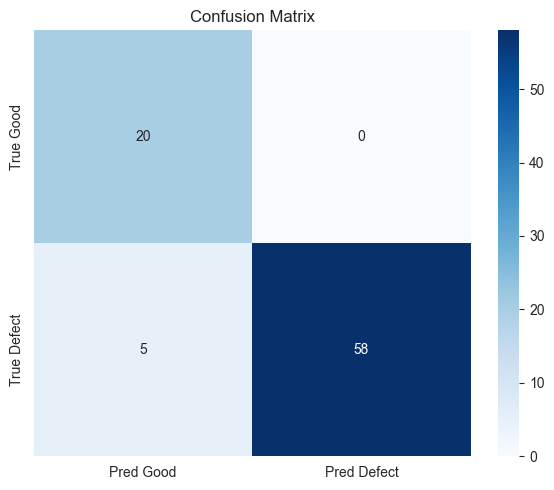

In [13]:
# Display inference results and aggregate evaluation
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

sns.set_style('whitegrid')

CATEGORIES = ['good', 'broken_large', 'broken_small', 'contamination']
base_dir = pathlib.Path('runs/inference_final')


def parse_results_file(results_file: pathlib.Path):
    records = []
    block = {}

    def flush_block():
        nonlocal block
        if block:
            records.append(block)
            block = {}

    with open(results_file, 'r') as f:
        for raw_line in f:
            clean = raw_line.strip()
            if not clean:
                flush_block()
                continue
            if clean.startswith('Image:'):
                flush_block()
                block = {'image': clean.split('Image:')[1].strip()}
            elif clean.startswith('Predicted:'):
                block['pred'] = clean.split('Predicted:')[1].strip()
            elif clean.startswith('Confidence:'):
                value = clean.split('Confidence:')[1].strip().replace('%', '')
                block['confidence'] = float(value) if value else None
            elif clean.startswith('Prob Good:'):
                value = clean.split('Prob Good:')[1].strip().replace('%', '')
                block['prob_good'] = float(value) if value else None
            elif clean.startswith('Prob Defect:'):
                value = clean.split('Prob Defect:')[1].strip().replace('%', '')
                block['prob_defect'] = float(value) if value else None
        flush_block()
    return records


inference_rows = []
summary_rows = []

for category in CATEGORIES:
    results_path = base_dir / category / 'results.txt'
    if not results_path.exists():
        print(f"⚠️  Missing file: {results_path}")
        summary_rows.append({
            'category': category,
            'total_images': 0,
            'pred_good': 0,
            'pred_defect': 0,
            'accuracy_%': 0.0
        })
        continue

    parsed = parse_results_file(results_path)
    if not parsed:
        print(f"⚠️  File {results_path} has no data")
        continue

    true_label = 'Good' if category == 'good' else 'Defect'
    correct = sum(1 for rec in parsed if rec.get('pred') == true_label)

    for rec in parsed:
        rec['category'] = category
    inference_rows.extend(parsed)

    summary_rows.append({
        'category': category,
        'total_images': len(parsed),
        'pred_good': sum(1 for rec in parsed if rec.get('pred') == 'Good'),
        'pred_defect': sum(1 for rec in parsed if rec.get('pred') == 'Defect'),
        'accuracy_%': round(correct / len(parsed) * 100, 2)
    })

if not inference_rows:
    print('⚠️  No inference data available for evaluation')
else:
    inference_df = pd.DataFrame(inference_rows)
    summary_df = pd.DataFrame(summary_rows)

    print('Inference overview by category:')
    display(summary_df)

    print('\nSample records:')
    display(inference_df[['category', 'image', 'pred', 'confidence']].head())

    # Prepare evaluation dataframe
    eval_df = inference_df.copy()
    eval_df['true'] = eval_df['category'].apply(lambda cat: 'Good' if cat == 'good' else 'Defect')
    eval_df = eval_df.dropna(subset=['pred'])
    eval_df['pred'] = eval_df['pred'].astype(str)
    eval_df['true'] = eval_df['true'].astype(str)

    print(f"\nTotal samples for evaluation: {len(eval_df)}")
    print(f"  - Good (true): {(eval_df['true'] == 'Good').sum()}")
    print(f"  - Defect (true): {(eval_df['true'] == 'Defect').sum()}")

    # Overall metrics
    accuracy = accuracy_score(eval_df['true'], eval_df['pred'])
    precision = precision_score(eval_df['true'], eval_df['pred'], pos_label='Defect')
    recall = recall_score(eval_df['true'], eval_df['pred'], pos_label='Defect')
    f1 = f1_score(eval_df['true'], eval_df['pred'], pos_label='Defect')

    print('\nOVERALL METRICS')
    print('=' * 60)
    print(f"Accuracy : {accuracy*100:.2f}%")
    print(f"Precision: {precision*100:.2f}%")
    print(f"Recall   : {recall*100:.2f}%")
    print(f"F1-Score : {f1*100:.2f}%")

    # Classification report
    print('\nCLASSIFICATION REPORT')
    print('=' * 60)
    print(classification_report(eval_df['true'], eval_df['pred'], target_names=['Good', 'Defect'], digits=4))

    # Confusion matrix
    cm = confusion_matrix(eval_df['true'], eval_df['pred'], labels=['Good', 'Defect'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Good', 'Pred Defect'], yticklabels=['True Good', 'True Defect'])
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
